## Temporal Graph Metrics and Macro Economics

This notebook provides a comprehensive analysis of degree distributions within temporal trade networks. By leveraging both empirical data and mathematical models, we aim to uncover the structural characteristics of trade networks and explore the fit of various distribution models to the observed data.

---

### Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Fit Graph to Model](#fit-graph-to-model)


In [1]:
# General Utilities
import os
import warnings
from pathlib import Path

# Data Handling and Processing
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt

# Custom Modules
from dataloader import DataLoader

# Set global visualization and warning options
warnings.filterwarnings("ignore")

### Load and Preprocess Dataset

In [2]:
# Load and preprocess dataset
hs_code = 282520
hs_label = "Lithium"

In [3]:
# Create dir for exporting plots
export_path = os.path.join("figures", hs_label)
Path(export_path).mkdir(parents=True, exist_ok=True)

In [4]:
# Load and preprocess dataset
loader = DataLoader(hs_code=hs_code)

_initialize_data took 54.2765 seconds


In [5]:
# Returns efficiently handled polar dataframe
df = loader.get_data()

In [6]:
# Extracts the distinct years
years = sorted(df['t'].unique())

In [7]:
# Get aggregated export and import over all products
baseline_df = loader.get_baseline(load_precompute=True)

In [8]:
# Get Networkx representation of baseline_df
yearly_graphs = loader.get_yearly_graphs(years)

In [9]:
yearly_baseline_graph = loader.get_yearly_baseline_graphs(baseline_df, years)

In [10]:
df

,t,i,j,k,v,q,export_country,import_country,description,iso3_o,...,tradeflow_imf_d,comlang_ethno,comcol,col45,comleg_pretrans,comleg_posttrans,col_dep_ever,empire,sibling_ever,scaled_sci_2021
0,2002,36,124,282520,7.627,2.211,Australia,Canada,Lithium oxide and hydroxide,AUS,...,1151881.5,1.0,0.0,0.0,1.0,1.0,0.0,,1.0,19159.0
1,2002,36,360,282520,15.395,1.120,Australia,Indonesia,Lithium oxide and hydroxide,AUS,...,1814127.625,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,NaN
2,2002,36,372,282520,1.874,0.008,Australia,Ireland,Lithium oxide and hydroxide,AUS,...,109872.336,1.0,0.0,0.0,1.0,1.0,0.0,,1.0,61908.0
3,2002,36,380,282520,2.748,0.003,Australia,Italy,Lithium oxide and hydroxide,AUS,...,1230163.625,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,7123.0
4,2002,36,554,282520,5.832,1.422,Australia,New Zealand,Lithium oxide and hydroxide,AUS,...,3335579.5,1.0,0.0,0.0,1.0,1.0,0.0,,1.0,247952.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10856,2022,842,757,282520,94.439,1.124,United States of America,Switzerland,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
10857,2022,842,764,282520,6188.819,89.237,United States of America,Thailand,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
10858,2022,842,784,282520,2476.180,87.011,United States of America,United Arab Emirates,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
10859,2022,842,792,282520,0.873,0.045,United States of America,Turkey,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [11]:
baseline_df

,t,import_country,export_country,v
0,2001,Afghanistan,Australia,319.378
1,2001,Afghanistan,Austria,142.477
2,2001,Afghanistan,Azerbaijan,190.776
3,2001,Afghanistan,Bahrain,4.266
4,2001,Afghanistan,Bangladesh,6008.931
...,...,...,...,...
672029,2022,Zimbabwe,United Kingdom,85564.157
672030,2022,Zimbabwe,United Rep. of Tanzania,15260.089
672031,2022,Zimbabwe,Uruguay,220.626
672032,2022,Zimbabwe,Viet Nam,251.952


### Fit Graph Model

In [12]:
def plot_degree_distributions(graph_list, labels):
    fig, ax = plt.subplots(figsize=(14, 8))
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '+']
    colors = plt.cm.tab10.colors

    for i, g in enumerate(graph_list):
        degrees = np.array([degree for _, degree in g.degree()])
        degrees = degrees[degrees > 0]  # Filter out nodes with degree 0

        unique, counts = np.unique(degrees, return_counts=True)
        probs = counts / np.sum(counts)

        sorted_indices = np.argsort(unique)
        unique = unique[sorted_indices]
        probs = probs[sorted_indices]

        ax.plot(unique, probs, linestyle='-', marker=markers[i % len(markers)],
                markersize=6, markeredgewidth=0.5, markeredgecolor='black',
                color=colors[i % len(colors)], label=labels[i])

    ax.loglog()
    ax.set_xlabel('$k$ (Degree)', fontsize=12)
    ax.set_ylabel('$P(k)$ (Probability)', fontsize=12)
    ax.set_title('Degree Distributions Comparison', fontweight='bold', fontsize=14)
    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Function to plot a single graph with multiple fits
def plot_single_graph_with_fits(G, name):
    fig, ax = plt.subplots(figsize=(10, 6))

    degree_sequence = np.array([d for _, d in G.degree()])
    k_values, counts = np.unique(degree_sequence, return_counts=True)
    probs = counts / counts.sum()

    nonzero = probs > 0
    k_values = k_values[nonzero]
    probs = probs[nonzero]

    ax.loglog(k_values, probs, 'o', label="Empirical Data", color='blue', markersize=3)

    ##################
    # Power-law fit
    ##################
    gamma = 1 + len(degree_sequence) / np.sum(np.log(degree_sequence / degree_sequence.min()))
    x_powerlaw = k_values
    y_powerlaw = x_powerlaw ** (-gamma)
    y_powerlaw /= y_powerlaw.sum()  # Normalization
    ax.loglog(x_powerlaw, y_powerlaw, label=f"Power-law Fit (γ={gamma:.2f})", color='red', linewidth=2)

    ##################
    # Poisson fit
    ##################
    lambda_poisson = np.mean(degree_sequence)
    y_poisson = stats.poisson.pmf(k_values, lambda_poisson)
    y_poisson /= y_poisson.sum()  # Normalization
    ax.loglog(k_values, y_poisson, label="Poisson Fit", color='green', linestyle='--', linewidth=2)

    ##################
    # Exponential fit
    ##################
    y_exponential = (1 / lambda_poisson) * np.exp(-k_values / lambda_poisson)
    y_exponential /= y_exponential.sum()  # Normalization
    ax.loglog(k_values, y_exponential, label="Exponential Fit", color='orange', linestyle='-.', linewidth=2)

    ax.set_xlim([0.8 * k_values.min(), k_values.max() * 1.2])
    ax.set_ylim([0.5 * probs.min(), probs.max() * 2])

    ax.set_xlabel("Degree (k)")
    ax.set_ylabel("Probability p(k)")
    ax.set_title(f"Degree Distribution for {name}", fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


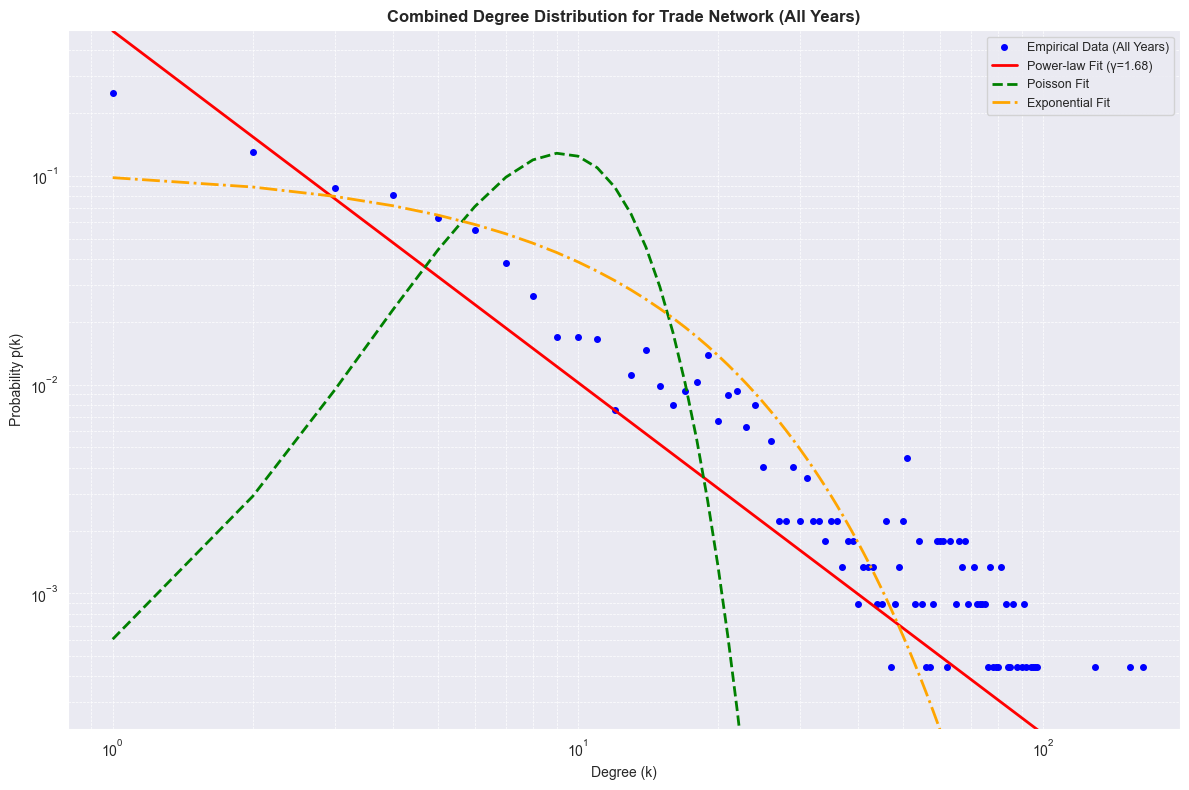

In [13]:
def compute_country_statistics(df):
    export_stats = df.groupby(["t", "export_country"])["q"].size().reset_index(name="num_exports")
    import_stats = df.groupby(["t", "import_country"])["q"].size().reset_index(name="num_imports")

    country_stats = pd.merge(
        export_stats,
        import_stats,
        left_on=["t", "export_country"],
        right_on=["t", "import_country"],
        how="outer"
    ).fillna(0)

    country_stats.rename(columns={"export_country": "country", "import_country": "country"}, inplace=True)

    country_stats["degree"] = country_stats["num_exports"] + country_stats["num_imports"]

    return country_stats[["t", "country", "degree"]]

def plot_degree_distribution_combined(df, name):
    # Combine degree sequences from all years
    degree_sequence = df["degree"].values
    k_values, counts = np.unique(degree_sequence, return_counts=True)
    probs = counts / counts.sum()

    nonzero = probs > 0
    k_values = k_values[nonzero]
    probs = probs[nonzero]

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot combined degree distribution
    ax.loglog(k_values, probs, 'o', label="Empirical Data (All Years)", color='blue', markersize=4)

    # Power-law fit
    gamma = 1 + len(degree_sequence) / np.sum(np.log(degree_sequence / degree_sequence.min()))
    y_powerlaw = k_values ** (-gamma)
    y_powerlaw /= y_powerlaw.sum()  # Normalize
    ax.loglog(k_values, y_powerlaw, label=f"Power-law Fit (γ={gamma:.2f})", color='red', linewidth=2)

    # Poisson fit
    lambda_poisson = np.mean(degree_sequence)
    y_poisson = stats.poisson.pmf(k_values, lambda_poisson)
    y_poisson /= y_poisson.sum()  # Normalize
    ax.loglog(k_values, y_poisson, label="Poisson Fit", color='green', linestyle='--', linewidth=2)

    # Exponential fit
    y_exponential = (1 / lambda_poisson) * np.exp(-k_values / lambda_poisson)
    y_exponential /= y_exponential.sum()  # Normalize
    ax.loglog(k_values, y_exponential, label="Exponential Fit", color='orange', linestyle='-.', linewidth=2)

    ax.set_xlim([0.8 * k_values.min(), k_values.max() * 1.2])
    ax.set_ylim([0.5 * probs.min(), probs.max() * 2])

    ax.set_xlabel("Degree (k)")
    ax.set_ylabel("Probability p(k)")
    ax.set_title(f"Combined Degree Distribution for {name} (All Years)", fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.savefig(
        os.path.join(export_path, f"{hs_label}_degree_distribution_centrality.png"),
        dpi=300,
        transparent=True
    )
    plt.show()


country_stats = compute_country_statistics(df)

plot_degree_distribution_combined(country_stats, "Trade Network")
